# Handling filter objects

The most fundamental building block of photometric surveys lies in the bandpass filters used to conduct them. In this example we will learn how to use the `Filter` class which is used in (nearly) every use-case of the `galfind` code. We start by looking at the JWST/NIRCam/F444W band, which is very commonly used in both blank field and cluster surveys.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from copy import copy, deepcopy

from galfind import Filter
from galfind import U, V, J

__init__ imports took 0.5126409530639648s
Reading GALFIND config file from: /nvme/scratch/work/austind/GALFIND/galfind/../configs/galfind_config.ini


In [2]:
# Example 1: Create a filter object from a filter name
facility = "JWST"
instrument = "NIRCam"
filter_name = "F444W"
f444w = Filter.from_SVO(facility, instrument, filter_name)

We can also very simply plot this filter profile so we can check that it looks correct. This in-built function also allows the user to choose the filter colour; we choose to plot this filter in red since it is the reddest wideband available for JWST/NIRCam.

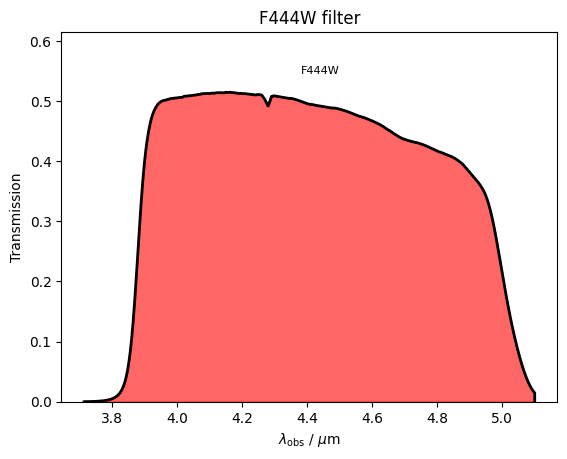

****************************************
FILTER: JWST/NIRCam/F444W
****************************************
DetectorType: photon counter
Description: NIRCam F444W filter
Comments: includes NIRCam optics, DBS, QE and JWST Optical Telescope Element
WavelengthRef: 44043.150837738 Angstrom
WavelengthMean: 44393.515120525 Angstrom
WavelengthEff: 43504.264673627 Angstrom
WavelengthMin: 38039.572043804 Angstrom
WavelengthMax: 50995.5 Angstrom
WidthEff: 10676.002928393 Angstrom
WavelengthCen: 44405.491515008 Angstrom
WavelengthPivot: 44043.150837738 Angstrom
WavelengthPeak: 43523.2 Angstrom
WavelengthPhot: 43732.035994545 Angstrom
FWHM: 11144.052434142 Angstrom
WavelengthUpper50: 49977.517732078995 Angstrom
WavelengthLower50: 38833.465297937 Angstrom
****************************************



In [3]:
# Example 2: Display filter and metadata
# Construct the axis to plot this filter on using matplotlib
fig, ax = plt.subplots()
f444w.plot(ax, colour = "red", show = True)

# Have a look at the meta properties of the filter
print(f444w)

In the above example, we have taken the filter profile (and associated properties) directly from the [SVO Filter Profile service]("http://svo2.cab.inta-csic.es/theory/fps/"). In addition to those available via SVO, `galfind` also provides a set of top-hat UVJ filters useful for the identification of passive galaxies at $z<4$ or so. When plotting these UVJ filters, we utilize the option to change the wavelength units that are plotted on the x axis. For more information on how `galfind` handles standard unit conversions, please see [Galfind unit conversions](../misc/units.ipynb).

****************************************
FILTER: U
****************************************
WavelengthCen: 3650.0 Angstrom
FWHM: 660.0 Angstrom
****************************************

****************************************
FILTER: V
****************************************
WavelengthCen: 5510.0 Angstrom
FWHM: 880.0 Angstrom
****************************************

****************************************
FILTER: J
****************************************
WavelengthCen: 12200.0 Angstrom
FWHM: 2130.0 Angstrom
****************************************



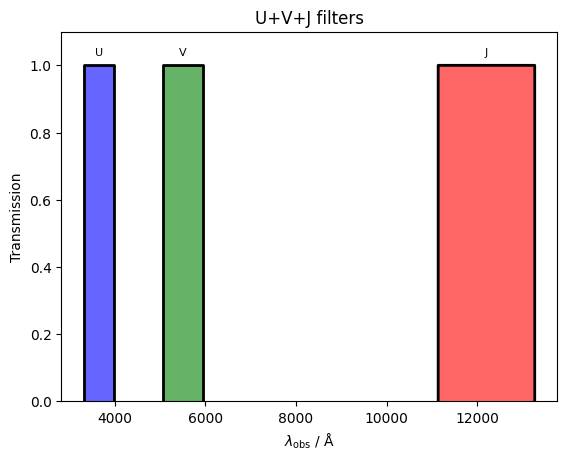

In [4]:
# Example 3: Create UVJ filters
# initialize the UVJ filters
U_filter = U()
V_filter = V()
J_filter = J()
filters_to_plot = [U_filter, V_filter, J_filter]

# plot the UVJ filters
fig, ax = plt.subplots()
# plotting meta
wav_units = u.AA
colours_to_plot = ["blue", "green", "red"]
for i, (filt, colour) in enumerate(zip(filters_to_plot, colours_to_plot)):
    # print string representation of the filter
    print(filt)
    # plot the filter on the axis
    filt.plot(ax, wav_units = wav_units, show = True if i == len(filters_to_plot) - 1 else False, colour = colour)


We have now learnt how to both load in filters directly from the SVO as well as access the UVJ filters built into `galfind` itself, but what if we have some strange filter not included in either. Maybe we want to test out some future instrument (for instance the ELT MICADO filterset), or maybe we want to procrastinate? Let's have a little fun shall we.

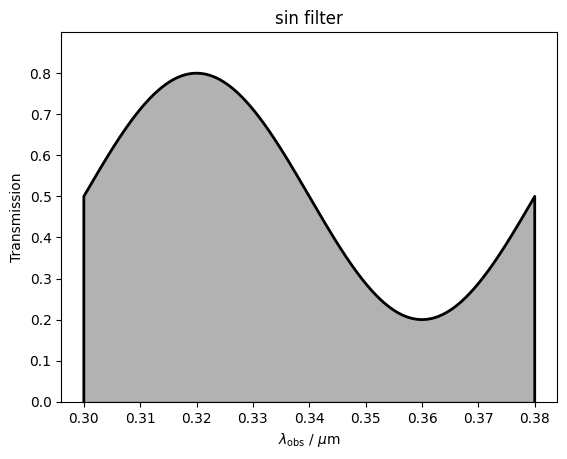

In [5]:
# Example 3: Create a custom filter
# define a sin function for the filter throughput about a 0.5 midpoint
def sin_func(x, wavelength, amplitude = 0.3, const = 0.5):
    return amplitude * np.sin(x * 2 * np.pi / wavelength) + const

# create a filter object from the custom function
wav = list(np.linspace(3_000., 3_800., 800)) * u.AA
trans = sin_func(wav.value - wav[0].value, 800)
properties = {}
sin_filt = Filter(None, "sin", wav, trans, properties = properties)
# plot the filter
fig, ax = plt.subplots()
sin_filt.plot(ax, colour = "grey", label = False, show = True)

Looks beautiful, although maybe not particularly realistic. Maybe we were attempting to re-create the F444W filter from JWST/NIRCam and want to check this without explicitly plotting it. In this case we use the overridden `==` operator which can be helpful for checking whether your `Filter` objects are identical or not.

In [6]:
# Example 4: Checking whether the sin and F444W filters are identical
if sin_filt == f444w:
    print(f"{repr(sin_filt)} and {repr(f444w)} are identical")
else:
    print(f"{repr(sin_filt)} and {repr(f444w)} are different")

Filter(sin) and Filter(F444W) are different


Finally, we ask the question about what to do if we want to use many of these filters at one time, as in photometric surveys. Since the $\sin$ and F444W filters are different, let's try collating their information together into a single object using the `+` operator.Be careful though, as the reserve operation will not yield the same object. We can see from the example below that the type of this is a `Multiple_Filter` class, which we cover in the [next notebook](multiple_filter.ipynb).

In [7]:
# Example 5: Adding filters together

# add the sin and F444W filters together
combined_filt = sin_filt + f444w
print(f"The type of the combined filter is {type(combined_filt)}\n")

# print the combined filter
print(combined_filt)

# attempt the reverse operation to regain the original sin filter
combined_filt -= f444w
if combined_filt == sin_filt:
    print(f"{repr(combined_filt)} and {repr(sin_filt)} are identical\n")
else:
    print(f"{repr(combined_filt)} and {repr(sin_filt)} are different\n")
print(combined_filt)

# show the difference between the two
if combined_filt[0] == sin_filt:
    print("combined_filt[0] == sin_filt")
else:
    print("combined_filt[0] != sin_filt")

The type of the combined filter is <class 'galfind.Filter.Multiple_Filter'>

****************************************
MULTIPLE_FILTER
****************************************
FACILITY: JWST
INSTRUMENT: NIRCam
FILTERS: ['F444W']
----------
FACILITY: UserDefined
INSTRUMENT: UserDefined
FILTERS: ['sin']
****************************************

Multiple_Filter(UserDefined) and Filter(sin) are different

****************************************
MULTIPLE_FILTER
****************************************
FACILITY: UserDefined
INSTRUMENT: UserDefined
FILTERS: ['sin']
****************************************

combined_filt[0] == sin_filt
